In [1]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/stefan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [159]:
from nltk.corpus import wordnet as wn

In [160]:
from nltk.corpus import semcor

In [161]:
# len(semcor.words())

In [162]:
len(semcor.fileids())

352

In [163]:
semcor.root

ZipFilePathPointer('/home/stefan/nltk_data/corpora/semcor.zip', 'semcor/')

In [164]:
from nltk.corpus.reader.semcor import SemcorCorpusReader

In [165]:
reader = SemcorCorpusReader(semcor.root, semcor.fileids(), wn)

In [166]:
len(reader.words(semcor.fileids()[150]))

2310

In [167]:
# for f in semcor.fileids():
#     print(len(reader.words(f)))

In [168]:
file = semcor.fileids()[7]

In [169]:
words = reader.words(file)
words

['Sizzling', 'temperatures', 'and', 'hot', 'summer', ...]

In [170]:
len(words)

2267

In [171]:
#pos tagging and lemmatization
from nltk.stem import WordNetLemmatizer

In [172]:
nltk.pos_tag(['refuse'])

[('refuse', 'NN')]

In [173]:
nltk.pos_tag(['they', 'refuse'])

[('they', 'PRP'), ('refuse', 'VBP')]

In [174]:
#pos tagging depends on context

In [175]:
tagged_words = nltk.pos_tag(words)

In [176]:
def to_wordnet_pos(nltk_pos):
    if nltk_pos == "J":
        return wn.ADJ
    elif nltk_pos == "N":
        return wn.NOUN
    elif nltk_pos == "V":
        return wn.VERB
    elif nltk_pos == "R":
        return wn.ADV
#     elif nltk_pos == "S":
#         return wn.ADJ_SAT
    else:
        return None

In [177]:
tagged_words = list(map(lambda pair: (pair[0], to_wordnet_pos(pair[1][0])), tagged_words))

In [178]:
tagged_words

[('Sizzling', 'v'),
 ('temperatures', 'n'),
 ('and', None),
 ('hot', 'a'),
 ('summer', 'n'),
 ('pavements', 'n'),
 ('are', 'v'),
 ('anything', 'n'),
 ('but', None),
 ('kind', 'n'),
 ('to', None),
 ('the', None),
 ('feet', 'n'),
 ('.', None),
 ('That', None),
 ('is', 'v'),
 ('why', None),
 ('it', None),
 ('is', 'v'),
 ('important', 'a'),
 ('to', None),
 ('invest', 'v'),
 ('in', None),
 ('comfortable', 'a'),
 (',', None),
 ('airy', 'a'),
 ('types', 'n'),
 ('of', None),
 ('shoes', 'n'),
 ('.', None),
 ('There', None),
 ('are', 'v'),
 ('many', 'a'),
 ('soft', 'a'),
 ('and', None),
 ('light', 'a'),
 ('shoe', 'n'),
 ('leathers', 'n'),
 ('available', 'a'),
 ('.', None),
 ('Many', 'a'),
 ('styles', 'n'),
 ('have', 'v'),
 ('perforations', 'n'),
 ('and', None),
 ('an', None),
 ('almost', 'r'),
 ('weightlessness', 'n'),
 ('achieved', 'v'),
 ('via', None),
 ('unlined', 'a'),
 ('leathers', 'n'),
 ('.', None),
 ('Softness', 'n'),
 ('is', 'v'),
 ('found', 'v'),
 ('in', None),
 ('crushed', 'a'),
 ('te

In [179]:
other_words = list(filter(lambda pair: pair[1] == None, tagged_words))

In [180]:
tagged_words = list(filter(lambda pair: pair[1] != None, tagged_words))

In [181]:
lemmatizer = WordNetLemmatizer()

In [182]:
lemmatized_words = [lemmatizer.lemmatize(w, tag) for (w, tag) in tagged_words]

In [183]:
lemmatized_words

['Sizzling',
 'temperature',
 'hot',
 'summer',
 'pavement',
 'be',
 'anything',
 'kind',
 'foot',
 'be',
 'be',
 'important',
 'invest',
 'comfortable',
 'airy',
 'type',
 'shoe',
 'be',
 'many',
 'soft',
 'light',
 'shoe',
 'leather',
 'available',
 'Many',
 'style',
 'have',
 'perforation',
 'almost',
 'weightlessness',
 'achieve',
 'unlined',
 'leather',
 'Softness',
 'be',
 'find',
 'crushed',
 'texture',
 'Styles',
 'run',
 'gamut',
 'slender',
 'taper',
 'elongated',
 'toe',
 'newer',
 'square',
 'toe',
 'shape',
 'Heels',
 'place',
 'emphasis',
 'long',
 'legged',
 'silhouette',
 'Wine',
 'glass',
 'heel',
 'be',
 'be',
 'find',
 'high',
 'semi-heights',
 'Stacked',
 'heel',
 'be',
 'also',
 'popular',
 'dressy',
 'tailor',
 'shoe',
 'Just',
 'bare',
 'suggestion',
 'heel',
 'be',
 'find',
 'teenage',
 'pump',
 'white',
 'be',
 'cool',
 'summer',
 'shade',
 'be',
 'lot',
 'pastel',
 'hue',
 'tintable',
 'fabric',
 'blend',
 'wardrobe',
 'color',
 'tintable',
 'group',
 'be',
 '

In [184]:
len(lemmatized_words)

1220

In [185]:
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /home/stefan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [186]:
english_stopwords = stopwords.words('english')

In [187]:
english_stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [188]:
import string

In [189]:
punctuation = string.punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [190]:
normalized_words = map(lambda x: x.lower(), lemmatized_words)

clean_words = list(filter(lambda x: x not in english_stopwords and x not in punctuation, normalized_words))

In [191]:
len(clean_words)

1038

In [192]:
wn.synsets('bertrand_russell')[0].lemmas()

[Lemma('russell.n.07.Russell'),
 Lemma('russell.n.07.Bertrand_Russell'),
 Lemma('russell.n.07.Bertrand_Arthur_William_Russell'),
 Lemma('russell.n.07.Earl_Russell')]

In [194]:
def wn_collocations(words):
    max_col_size = 5
    for col_size in range(max_col_size, 1, -1):
        i = 0
        while i <= len(words) - col_size:
            col = "_".join([words[j] for j in range(i, i + col_size)])
            if len(wn.synsets(col)) != 0:
                words[i] = col
                for j in range(i + col_size - 1, i, -1):
                    del words[j]
                print(col, len(wn.synsets(col)))
            i+=1

In [195]:
wn_collocations(test_words)

Bertrand_Arthur_William_Russell 1


In [196]:
test_words

['I', 'am', 'Bertrand_Arthur_William_Russell']

In [197]:
print(len(clean_words))
wn_collocations(clean_words)
len(clean_words)

1038
thomas_alva_edison 1
frank_lloyd_wright 1
i._a._richards 1
stephen_vincent_benet 1
shoe_leather 1
stacked_heel 1
basket_weave 1
open_weave 1
wedge_heel 1
open_weave 1
white_leather 1
electric_toothbrush 1
take_place 1
electric_razor 1
index_finger 1
electric_razor 1
electric_toothbrush 1
jacket_crown 1
cerebral_palsy 1
muscular_dystrophy 1
left_hand 1
brain_tumor 1
steam_bath 2
sweat_glands 1
functional_disorder 1
multiple_sclerosis 1
back_brace 1
thyroid_gland 1
party_game 1
wise_men 2
carl_sandburg 1
jawaharlal_nehru 1
jacques_lipchitz 1
sean_o'casey 1
bertrand_russell 1
modern_greek 1
carl_sandburg 1
john_ciardi 1
elementary_school 1
inferiority_complex 1
professional_dancer 1
stock_market 1
easy_money 2
best_seller 1
picture_book 1
gas_stove 1


988

In [198]:
#remove duplicates
clean_words = list(set(clean_words))

In [199]:
len(clean_words)

721

In [200]:
word_senses = dict([(w, None) for w in clean_words])
word_senses

{'p.': None,
 'taper': None,
 'circle': None,
 'company': None,
 'face': None,
 'guess': None,
 'submit': None,
 'library': None,
 'know': None,
 'philosopher': None,
 'disease': None,
 'responsible': None,
 'lustre': None,
 'ile': None,
 'deliver': None,
 'interpret': None,
 'adventures': None,
 'highlight': None,
 'way': None,
 'man': None,
 'fabric': None,
 'wheelock': None,
 'effort': None,
 'electric': None,
 'include': None,
 'laboratory': None,
 'experience': None,
 'family': None,
 'upset': None,
 'come': None,
 'history': None,
 'also': None,
 'however': None,
 'volumes': None,
 'ordinary': None,
 'lack': None,
 'prevent': None,
 'handicap': None,
 'poet': None,
 'institute': None,
 'maxwell': None,
 'toe': None,
 'strong': None,
 'nautical': None,
 'sewer': None,
 'recognize': None,
 'nerve': None,
 'howard': None,
 'marksmanship': None,
 'illustrate': None,
 'go': None,
 'enjoyable': None,
 'attitude': None,
 'problem': None,
 'arts': None,
 'muscle': None,
 'newest': None,


In [201]:
import networkx as nx

In [202]:
G = nx.Graph()

In [203]:
for w in clean_words:
    w_synsets = wn.synsets(w)
    if len(w_synsets) > 1:
        for synset in w_synsets:
            G.add_node((w, synset))
    elif len(w_synsets) == 1:
        word_senses[w] = w_synsets[0]
#     if there are no synsets - leave None
#                 G.add_node(synset.name())

In [204]:
G

In [205]:
len(G.nodes)

5029

In [206]:
def are_connected(u, v):
    if u in v.hypernyms() or u in v.hyponyms() or u in v.part_holonyms() or u in v.part_meronyms() or u in v.substance_holonyms() or u in v.substance_meronyms():
        return True
#     coordinate relation - e.g. wolf and dog
    u_hyper = set(u.hypernyms())
    v_hyper = set(v.hypernyms())
    if len(u_hyper & v_hyper) > 0:
        return True

In [207]:
# nodes_to_draw = []
for node_i in G.nodes:
    for node_j in G.nodes:
        if node_i[0] != node_j[0] and are_connected(node_i[1], node_j[1]):
            G.add_edge(node_i, node_j)
#             nodes_to_draw.append(node_i)
#             nodes_to_draw.append(node_j)
#             print(node_i, node_j)

In [208]:
len(list(G.edges))

9073

In [55]:
len(nodes_to_draw)

38120

In [32]:
from matplotlib import pyplot as plt

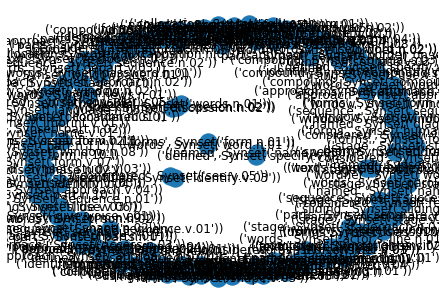

In [33]:
nx.draw(G, with_labels=True)

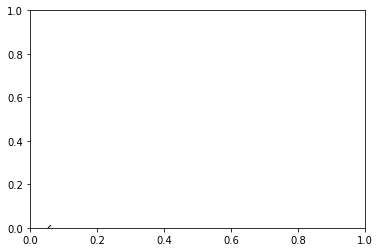

In [34]:
nx.draw_networkx_edges(G, pos=nx.spring_layout(G))

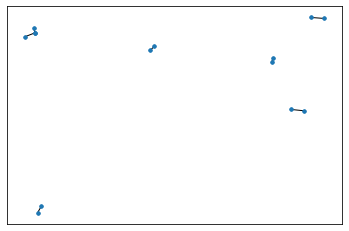

In [56]:
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos=pos, nodelist=nodes_to_draw, node_size=10)
nx.draw_networkx_edges(G, pos=pos, nodelist=nodes_to_draw)

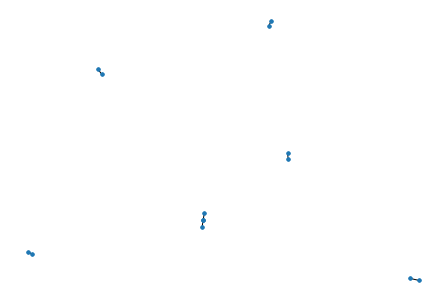

In [46]:
nx.draw(G, node_size=10, nodelist=nodes_to_draw, edgelist=G.edges)

In [47]:
nodes_to_draw

[('text', Synset('text.n.01')),
 ('words', Synset('lyric.n.01')),
 ('text', Synset('text.n.02')),
 ('words', Synset('bible.n.01')),
 ('speech', Synset('speech.n.02')),
 ('words', Synset('words.n.01')),
 ('speech', Synset('speech.n.02')),
 ('words', Synset('discussion.n.02')),
 ('identified', Synset('identify.v.03')),
 ('considered', Synset('see.v.05')),
 ('considered', Synset('see.v.05')),
 ('identified', Synset('identify.v.03')),
 ('words', Synset('words.n.01')),
 ('speech', Synset('speech.n.02')),
 ('words', Synset('lyric.n.01')),
 ('text', Synset('text.n.01')),
 ('words', Synset('word.n.01')),
 ('forms', Synset('form.n.01')),
 ('words', Synset('discussion.n.02')),
 ('speech', Synset('speech.n.02')),
 ('words', Synset('bible.n.01')),
 ('text', Synset('text.n.02')),
 ('forms', Synset('form.n.01')),
 ('words', Synset('word.n.01')),
 ('defined', Synset('specify.v.02')),
 ('named', Synset('name.v.05')),
 ('named', Synset('name.v.05')),
 ('defined', Synset('specify.v.02'))]

In [56]:
edges = list(G.edges)

In [57]:
[edges[0][0], edges[0][1]]

[('answer', Synset('answer.n.01')), ('condition', Synset('condition.n.07'))]

In [59]:
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, nodelist=[edges[0][0], edges[0][1]])
# nx.draw_networkx_labels(G, pos, nodelist=[edges[0][0], edges[0][1]])

KeyboardInterrupt: 

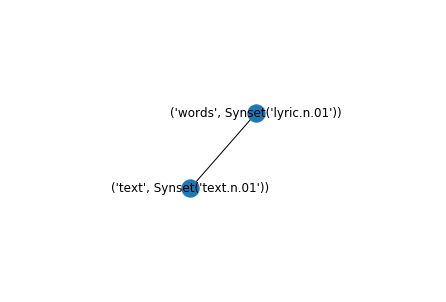

In [62]:
nx.draw(G, pos, nodelist=[edges[0][0], edges[0][1]], with_labels=True)

In [209]:
pr = nx.pagerank(G)

In [210]:
pr

{('taper', Synset('taper.n.01')): 4.7097241078810154e-05,
 ('taper', Synset('taper.n.02')): 4.7097241078810154e-05,
 ('taper', Synset('wick.n.02')): 4.7097241078810154e-05,
 ('taper', Synset('candle.n.01')): 0.0003139321972377798,
 ('taper', Synset('taper.v.01')): 0.00037063200159120446,
 ('taper', Synset('sharpen.v.07')): 0.00031393219723777977,
 ('circle', Synset('circle.n.01')): 0.0003139321972377798,
 ('circle', Synset('set.n.05')): 0.00034513938891047013,
 ('circle', Synset('circle.n.03')): 0.0002716207226520354,
 ('circle', Synset('lap.n.05')): 0.0001986193250784806,
 ('circle', Synset('traffic_circle.n.01')): 4.7097241078810154e-05,
 ('circle', Synset('r-2.n.01')): 4.7097241078810154e-05,
 ('circle', Synset('circle.n.07')): 4.7097241078810154e-05,
 ('circle', Synset('circle.n.08')): 0.0003139321972377798,
 ('circle', Synset('circle.v.01')): 0.0003509291578746722,
 ('circle', Synset('circle.v.02')): 0.0003509291578746722,
 ('circle', Synset('encircle.v.01')): 0.000152411340189564

In [218]:
max_values = dict([(w, 0.0) for w in clean_words])

In [219]:
max_values

{'p.': 0.0,
 'taper': 0.0,
 'circle': 0.0,
 'company': 0.0,
 'face': 0.0,
 'guess': 0.0,
 'submit': 0.0,
 'library': 0.0,
 'know': 0.0,
 'philosopher': 0.0,
 'disease': 0.0,
 'responsible': 0.0,
 'lustre': 0.0,
 'ile': 0.0,
 'deliver': 0.0,
 'interpret': 0.0,
 'adventures': 0.0,
 'highlight': 0.0,
 'way': 0.0,
 'man': 0.0,
 'fabric': 0.0,
 'wheelock': 0.0,
 'effort': 0.0,
 'electric': 0.0,
 'include': 0.0,
 'laboratory': 0.0,
 'experience': 0.0,
 'family': 0.0,
 'upset': 0.0,
 'come': 0.0,
 'history': 0.0,
 'also': 0.0,
 'however': 0.0,
 'volumes': 0.0,
 'ordinary': 0.0,
 'lack': 0.0,
 'prevent': 0.0,
 'handicap': 0.0,
 'poet': 0.0,
 'institute': 0.0,
 'maxwell': 0.0,
 'toe': 0.0,
 'strong': 0.0,
 'nautical': 0.0,
 'sewer': 0.0,
 'recognize': 0.0,
 'nerve': 0.0,
 'howard': 0.0,
 'marksmanship': 0.0,
 'illustrate': 0.0,
 'go': 0.0,
 'enjoyable': 0.0,
 'attitude': 0.0,
 'problem': 0.0,
 'arts': 0.0,
 'muscle': 0.0,
 'newest': 0.0,
 'elongated': 0.0,
 'learn': 0.0,
 'change': 0.0,
 'dolla

In [221]:
for k, v in pr.items():
    if v > max_values[k[0]]:
        word_senses[k[0]] = k[1]

In [222]:
word_senses

{'p.': None,
 'taper': Synset('sharpen.v.07'),
 'circle': Synset('encircle.v.01'),
 'company': Synset('company.v.01'),
 'face': Synset('face.v.09'),
 'guess': Synset('guess.v.04'),
 'submit': Synset('resign.v.04'),
 'library': Synset('library.n.05'),
 'know': Synset('know.v.11'),
 'philosopher': Synset('philosopher.n.02'),
 'disease': Synset('disease.n.01'),
 'responsible': Synset('creditworthy.s.01'),
 'lustre': Synset('shininess.n.01'),
 'ile': None,
 'deliver': Synset('give_birth.v.01'),
 'interpret': Synset('understand.v.03'),
 'adventures': Synset('venture.v.03'),
 'highlight': Synset('highlight.v.02'),
 'way': Synset('way.r.01'),
 'man': Synset('man.v.02'),
 'fabric': Synset('framework.n.02'),
 'wheelock': None,
 'effort': Synset('campaign.n.02'),
 'electric': Synset('electric.s.03'),
 'include': Synset('admit.v.03'),
 'laboratory': Synset('testing_ground.n.01'),
 'experience': Synset('have.v.11'),
 'family': Synset('family.n.08'),
 'upset': Synset('overturned.s.01'),
 'come': Sy

In [236]:
wn.synset('library.n.05').lemma_names()

['library']